In [3]:
# Step 1: Imports and setup

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image
import random
import warnings

# Optional: Ignore minor warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Path to your audio folders
real_audio_dir = "C:/Users/gavin/Documents/Dataset/AUDIO/REAL/"
fake_audio_dir = "C:/Users/gavin/Documents/Dataset/AUDIO/FAKE/"

# Audio and spectrogram settings
SAMPLE_RATE = 22050      # Standard sampling rate
DURATION = 3             # Duration of each sample in seconds
SAMPLES_PER_FILE = SAMPLE_RATE * DURATION
N_MELS = 128             # Number of mel bands
SPEC_WIDTH = 128         # Width of spectrogram crop (time dimension)

# Input shape for CNN: (height, width, channels)
INPUT_SHAPE = (N_MELS, SPEC_WIDTH, 1)


In [4]:
# Step 2: Load audio and extract mel spectrogram crops

def extract_mel_spectrogram_crops(file_path, label, duration=3, sample_rate=22050, n_mels=128, spec_width=128):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    total_samples = audio.shape[0]
    crops = []

    # Slide a window through the audio and extract crops
    step = int(sample_rate * duration)
    for start in range(0, total_samples - step, step):  # no overlap
        end = start + step
        segment = audio[start:end]
        mel = librosa.feature.melspectrogram(y=segment, sr=sample_rate, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Ensure consistent shape
        if mel_db.shape[1] >= spec_width:
            mel_db = mel_db[:, :spec_width]  # crop if too long
            crops.append((mel_db, label))

    return crops

# Gather all data
all_data = []

# Process FAKE files (no need to crop many times, we already have lots)
for fname in os.listdir(fake_audio_dir):
    if fname.endswith(".wav"):
        path = os.path.join(fake_audio_dir, fname)
        crops = extract_mel_spectrogram_crops(path, label="FAKE")
        all_data.extend(crops)

# Process REAL files (we'll extract as many crops as possible from each to balance)
for fname in os.listdir(real_audio_dir):
    if fname.endswith(".wav"):
        path = os.path.join(real_audio_dir, fname)
        crops = extract_mel_spectrogram_crops(path, label="REAL")
        all_data.extend(crops)

print(f"Total samples collected: {len(all_data)}")


Total samples collected: 9941


In [5]:
# Step 3: Preprocess and prepare data

# Shuffle the data
random.shuffle(all_data)

# Separate spectrograms and labels
spectrograms = [item[0] for item in all_data]
labels = [item[1] for item in all_data]

# Normalize and reshape spectrograms
X = np.array(spectrograms)
X = (X - X.min()) / (X.max() - X.min())  # normalize to 0-1
X = X[..., np.newaxis]  # add channel dimension -> (N, 128, 128, 1)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)  # FAKE -> 0, REAL -> 1
y = to_categorical(y_encoded, num_classes=2)     # one-hot encode

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Show dataset shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Labels:", label_encoder.classes_)


X_train shape: (7952, 128, 128, 1)
y_train shape: (7952, 2)
X_test shape: (1989, 128, 128, 1)
y_test shape: (1989, 2)
Labels: ['FAKE' 'REAL']


In [6]:
# Step 4: Define and train the CNN model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 128s 245ms/step - accuracy: 0.8757 - loss: 0.3694 - val_accuracy: 0.8904 - val_loss: 0.2715
Epoch 2/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 144s 249ms/step - accuracy: 0.8958 - loss: 0.2889 - val_accuracy: 0.8949 - val_loss: 0.2378
Epoch 3/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 121s 243ms/step - accuracy: 0.8979 - loss: 0.2275 - val_accuracy: 0.8979 - val_loss: 0.2026
Epoch 4/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 144s 246ms/step - accuracy: 0.9125 - loss: 0.1926 - val_accuracy: 0.9226 - val_loss: 0.1934
Epoch 5/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 122s 245ms/step - accuracy: 0.9357 - loss: 0.1596 - val_accuracy: 0.9301 - val_loss: 0.1575
Epoch 6/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 153s 266ms/step - accuracy: 0.9448 - loss: 0.1394 - val_accuracy: 0.9457 - val_loss: 0.1421
Epoch 7/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 132s 266ms/step - accuracy: 0.9486 - loss: 0.1239 - val_accuracy: 0.9452 - val_loss: 0.1471
Epoch 8/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 124s 249ms/step - accuracy: 0.9602 -

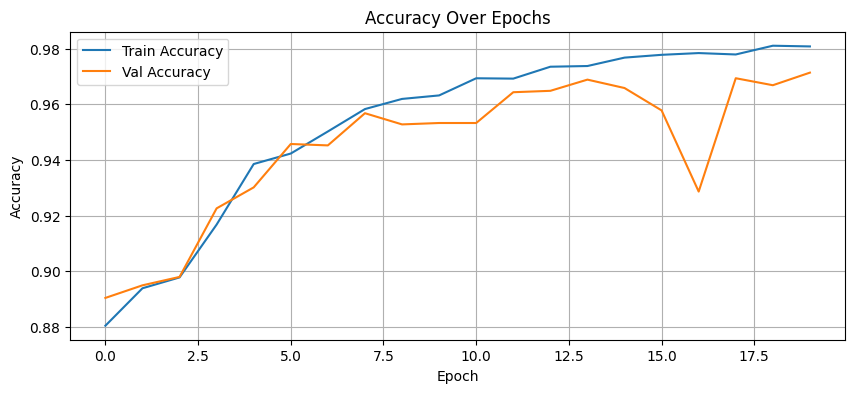

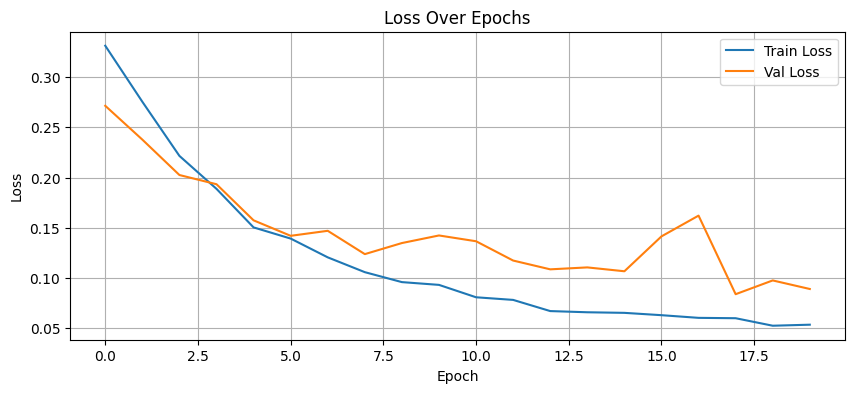

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step


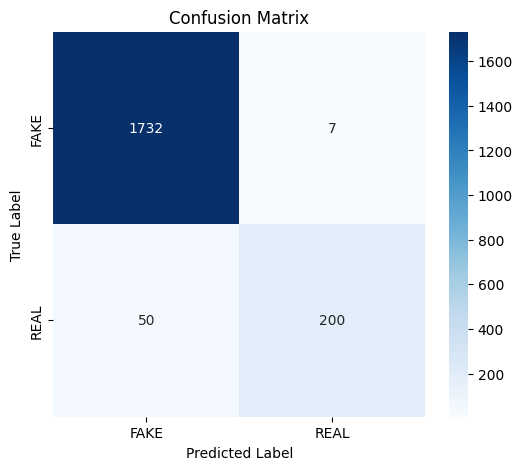


Classification Report:

              precision    recall  f1-score   support

        FAKE       0.97      1.00      0.98      1739
        REAL       0.97      0.80      0.88       250

    accuracy                           0.97      1989
   macro avg       0.97      0.90      0.93      1989
weighted avg       0.97      0.97      0.97      1989



In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
labels = label_encoder.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=labels))


In [9]:
# Save the model to an HDF5 file
model.save("voice_classifier_model.h5")
print("Model saved as voice_classifier_model.h5")

Model saved as voice_classifier_model.h5


In [30]:
import os
import random
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# Define your paths
real_audio_dir = "C:/Users/gavin/Documents/Dataset/AUDIO/REAL/"
fake_audio_dir = "C:/Users/gavin/Documents/Dataset/AUDIO/FAKE/"

# Load the saved model if not already loaded
# model = load_model("voice_classifier_model.h5")  # Uncomment if needed

# Predict function
def predict_random_file(real_dir, fake_dir, model, sample_rate=22050, duration=3, n_mels=128, spec_width=128):
    label_folder = random.choice([("REAL", real_dir), ("FAKE", fake_dir)])
    label, folder = label_folder

    files = [f for f in os.listdir(folder) if f.endswith(".wav")]
    file_name = random.choice(files)
    file_path = os.path.join(folder, file_name)

    audio, sr = librosa.load(file_path, sr=sample_rate)
    audio = audio[:sample_rate * duration]  # First 3 seconds

    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] < spec_width:
        pad_width = spec_width - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :spec_width]

    X = mel_db[np.newaxis, ..., np.newaxis]  # (1, 128, 128, 1)
    prediction = model.predict(X)[0]
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]

    print(f"\n🎧 File tested: {file_name}")
    print(f"✅ True label: {label}")
    print(f"🤖 Model prediction: {predicted_label}")
    print(f"🔢 Raw prediction (softmax): {prediction}")

# Run a test
predict_random_file(real_audio_dir, fake_audio_dir, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step

🎧 File tested: taylor-original.wav
✅ True label: REAL
🤖 Model prediction: FAKE
🔢 Raw prediction (softmax): [1. 0.]


In [31]:
def predict_multiple_random_files(real_dir, fake_dir, model, n=10, sample_rate=22050, duration=3, n_mels=128, spec_width=128):
    # Refit the label encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(["FAKE", "REAL"])  # must match training

    for i in range(n):
        # Randomly choose between REAL or FAKE
        label_folder = random.choice([("REAL", real_dir), ("FAKE", fake_dir)])
        label, folder = label_folder

        # Choose a random .wav file
        files = [f for f in os.listdir(folder) if f.endswith(".wav")]
        file_name = random.choice(files)
        file_path = os.path.join(folder, file_name)

        # Load and trim audio
        audio, sr = librosa.load(file_path, sr=sample_rate)
        audio = audio[:sample_rate * duration]

        # Create mel spectrogram
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Normalize
        mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())

        # Pad or crop to 128x128
        if mel_db.shape[1] < spec_width:
            pad_width = spec_width - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_db = mel_db[:, :spec_width]

        # Format for model input
        X = mel_db[np.newaxis, ..., np.newaxis]

        # Predict
        prediction = model.predict(X)[0]
        predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]

        # Print result
        print(f"\n🔎 Sample {i+1}")
        print(f"🎧 File: {file_name}")
        print(f"✅ True label: {label}")
        print(f"🤖 Predicted label: {predicted_label}")
        print(f"🔢 Raw prediction: {prediction}")


In [32]:
predict_multiple_random_files(real_audio_dir, fake_audio_dir, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step

🔎 Sample 1
🎧 File: musk-original.wav
✅ True label: REAL
🤖 Predicted label: REAL
🔢 Raw prediction: [2.615086e-21 1.000000e+00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

🔎 Sample 2
🎧 File: margot-original.wav
✅ True label: REAL
🤖 Predicted label: REAL
🔢 Raw prediction: [0.01541442 0.9845856 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step

🔎 Sample 3
🎧 File: margot-to-taylor.wav
✅ True label: FAKE
🤖 Predicted label: FAKE
🔢 Raw prediction: [9.990089e-01 9.910562e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

🔎 Sample 4
🎧 File: linus-original.wav
✅ True label: REAL
🤖 Predicted label: REAL
🔢 Raw prediction: [0.0365472  0.96345276]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

🔎 Sample 5
🎧 File: trump-original.wav
✅ True label: REAL
🤖 Predicted label: REAL
🔢 Raw prediction: [5.9386063e-04 9.9940610e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

🔎 Sample 6
🎧 File: trump-to-margot.wav
✅ True label: FAKE
🤖 Predicted label: FAKE
🔢 Raw prediction: [1. 0.]
1/1 ━━━━━━━━━━━━━━━━━

In [33]:
# Batch Testing
import pandas as pd

def evaluate_dataset(real_dir, fake_dir, model, sample_rate=22050, duration=3, n_mels=128, spec_width=128):
    label_encoder = LabelEncoder()
    label_encoder.fit(["FAKE", "REAL"])

    results = []

    for label, folder in [("REAL", real_dir), ("FAKE", fake_dir)]:
        files = [f for f in os.listdir(folder) if f.endswith(".wav")]

        for file_name in files:
            file_path = os.path.join(folder, file_name)

            # Load and crop
            audio, sr = librosa.load(file_path, sr=sample_rate)
            audio = audio[:sample_rate * duration]

            # Spectrogram
            mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())

            # Resize
            if mel_db.shape[1] < spec_width:
                pad_width = spec_width - mel_db.shape[1]
                mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mel_db = mel_db[:, :spec_width]

            # Predict
            X = mel_db[np.newaxis, ..., np.newaxis]
            prediction = model.predict(X)[0]
            predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
            confidence = float(np.max(prediction))

            # Store result
            results.append({
                "filename": file_name,
                "true_label": label,
                "predicted_label": predicted_label,
                "confidence": confidence
            })

    # Create dataframe
    df_results = pd.DataFrame(results)
    return df_results


In [34]:
df = evaluate_dataset(real_audio_dir, fake_audio_dir, model)
print(df.head())
print("\n✅ Total evaluated:", len(df))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [35]:
# Save the evaluation results to a CSV file
df.to_csv("voice_predictions.csv", index=False)
print("✅ Predictions saved to voice_predictions.csv")

✅ Predictions saved to voice_predictions.csv


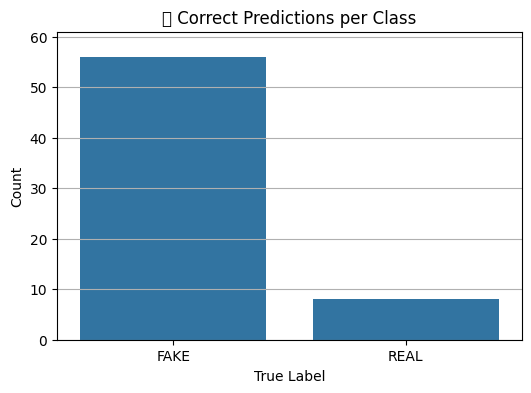

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count correct predictions per class
class_counts = df[df["true_label"] == df["predicted_label"]]["true_label"].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("✅ Correct Predictions per Class")
plt.ylabel("Count")
plt.xlabel("True Label")
plt.ylim(0, class_counts.max() + 5)
plt.grid(axis='y')
plt.show()

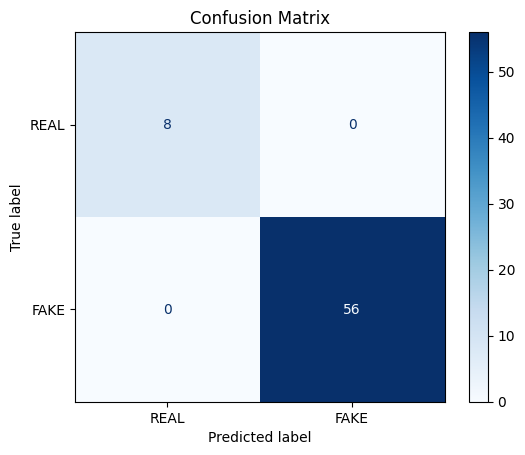

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df["true_label"], df["predicted_label"], labels=["REAL", "FAKE"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [42]:
def predict_and_show_multiple_spectrograms(real_dir, fake_dir, model, count=15, sample_rate=22050, duration=3, n_mels=128, spec_width=128):
    label_encoder = LabelEncoder()
    label_encoder.fit(["FAKE", "REAL"])

    for i in range(count):
        # Pick a random file
        label_folder = random.choice([("REAL", real_dir), ("FAKE", fake_dir)])
        label, folder = label_folder
        file_name = random.choice([f for f in os.listdir(folder) if f.endswith(".wav")])
        file_path = os.path.join(folder, file_name)

        # Load and crop
        audio, sr = librosa.load(file_path, sr=sample_rate)
        audio = audio[:sample_rate * duration]

        # Generate mel spectrogram
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())

        if mel_db.shape[1] < spec_width:
            pad_width = spec_width - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_db = mel_db[:, :spec_width]

        # Prepare input
        X = mel_db[np.newaxis, ..., np.newaxis]
        prediction = model.predict(X)[0]
        predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
        confidence = np.max(prediction)

        # Output
        print(f"\n🔎 Sample {i + 1}")
        print(f"🎧 File: {file_name}")
        print(f"✅ True label: {label}")
        print(f"🤖 Predicted: {predicted_label} ({confidence:.2%} confidence)")
        print(f"🔢 Softmax: {prediction}")

        # Plot spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
        plt.title(f"{file_name} | True: {label} | Predicted: {predicted_label}")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

🔎 Sample 1
🎧 File: linus-original.wav
✅ True label: REAL
🤖 Predicted: REAL (96.35% confidence)
🔢 Softmax: [0.0365472  0.96345276]


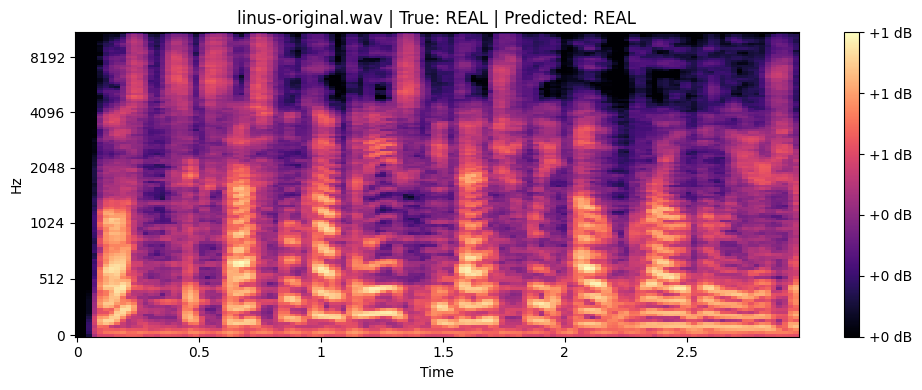

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step

🔎 Sample 2
🎧 File: taylor-to-trump.wav
✅ True label: FAKE
🤖 Predicted: FAKE (100.00% confidence)
🔢 Softmax: [1.000000e+00 7.910263e-15]


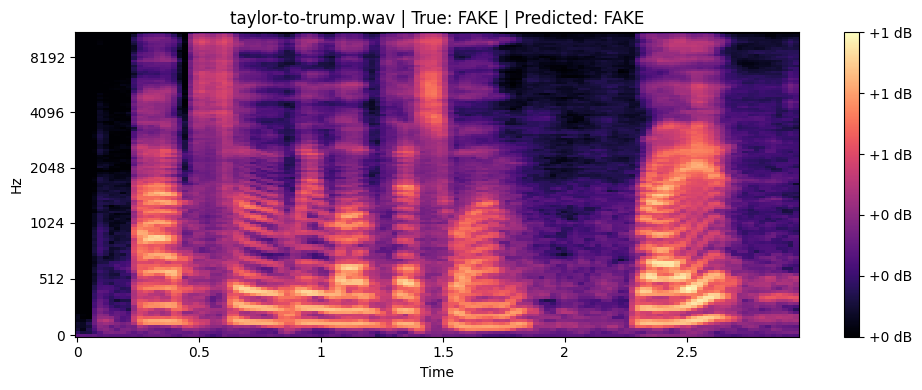

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

🔎 Sample 3
🎧 File: trump-original.wav
✅ True label: REAL
🤖 Predicted: REAL (99.94% confidence)
🔢 Softmax: [5.9386063e-04 9.9940610e-01]


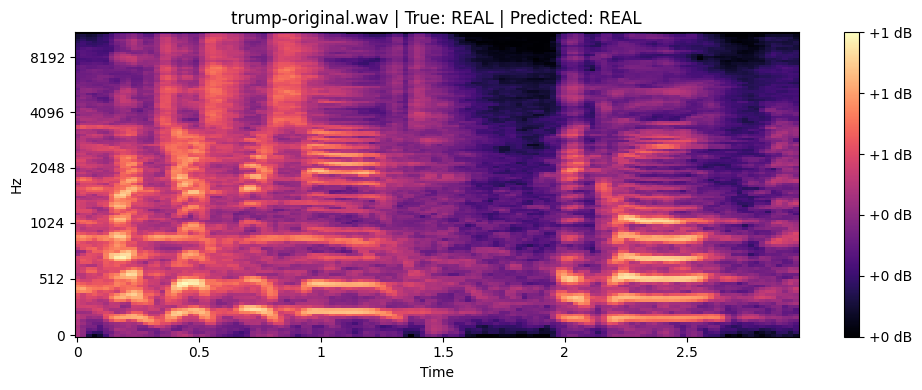

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

🔎 Sample 4
🎧 File: linus-original.wav
✅ True label: REAL
🤖 Predicted: REAL (96.35% confidence)
🔢 Softmax: [0.0365472  0.96345276]


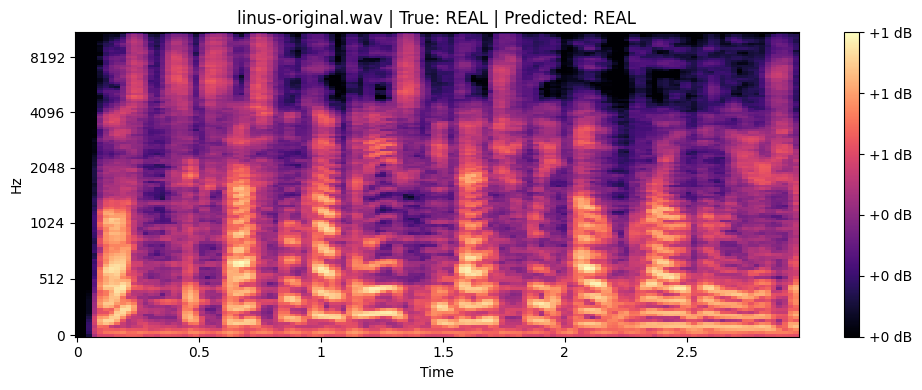

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step

🔎 Sample 5
🎧 File: biden-original.wav
✅ True label: REAL
🤖 Predicted: REAL (99.98% confidence)
🔢 Softmax: [2.4180596e-04 9.9975818e-01]


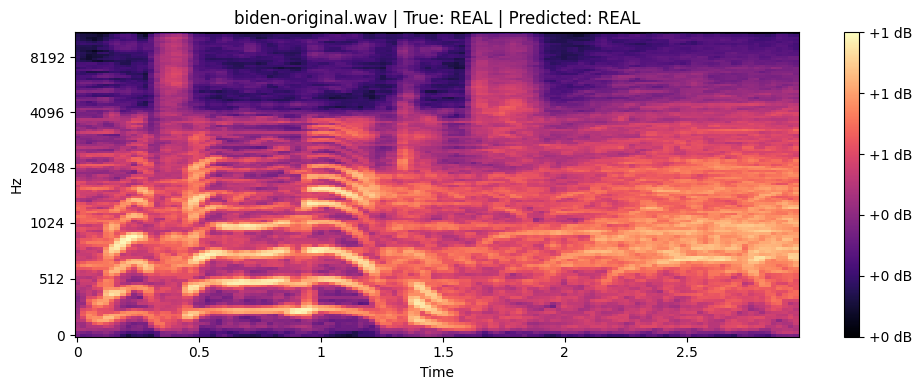

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

🔎 Sample 6
🎧 File: margot-to-trump.wav
✅ True label: FAKE
🤖 Predicted: FAKE (96.97% confidence)
🔢 Softmax: [0.9697054 0.0302946]


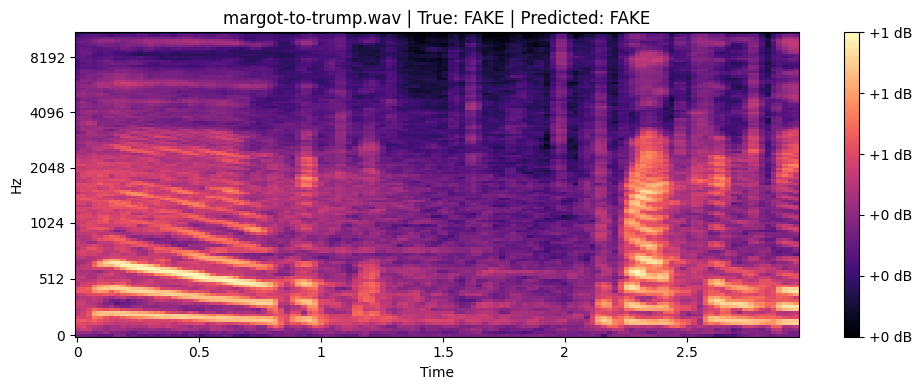

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

🔎 Sample 7
🎧 File: margot-original.wav
✅ True label: REAL
🤖 Predicted: REAL (98.46% confidence)
🔢 Softmax: [0.01541442 0.9845856 ]


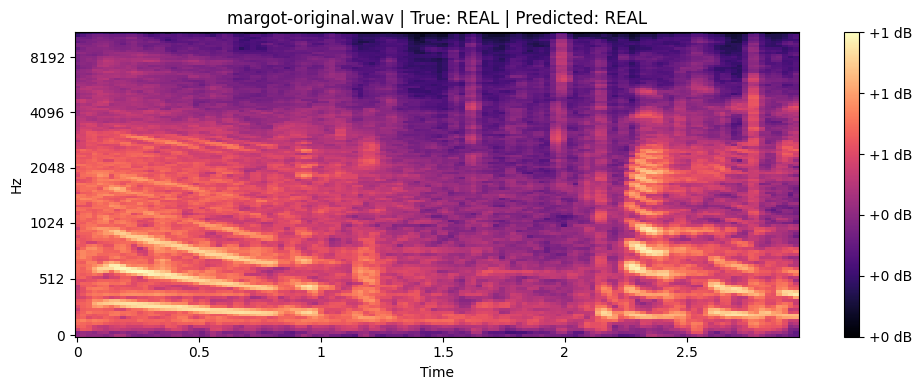

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

🔎 Sample 8
🎧 File: trump-original.wav
✅ True label: REAL
🤖 Predicted: REAL (99.94% confidence)
🔢 Softmax: [5.9386063e-04 9.9940610e-01]


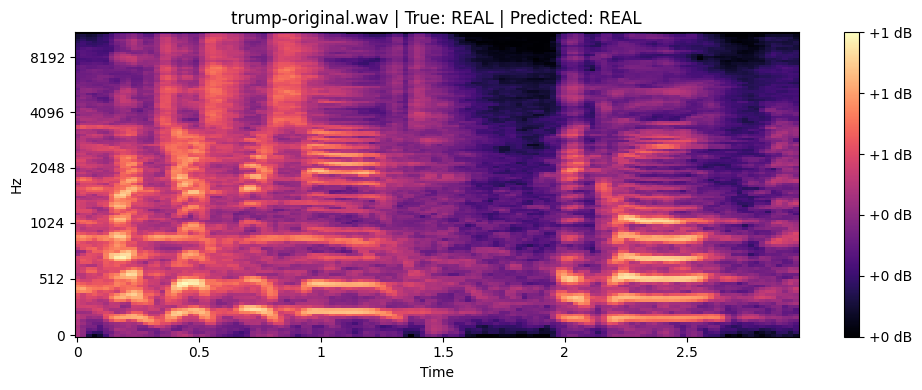

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step

🔎 Sample 9
🎧 File: obama-original.wav
✅ True label: REAL
🤖 Predicted: REAL (99.84% confidence)
🔢 Softmax: [0.00162831 0.99837166]


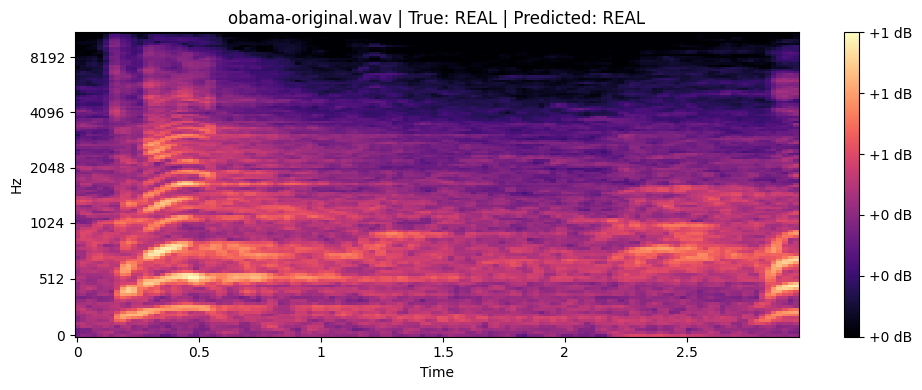

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step

🔎 Sample 10
🎧 File: biden-to-ryan.wav
✅ True label: FAKE
🤖 Predicted: FAKE (100.00% confidence)
🔢 Softmax: [1.0000000e+00 1.1805714e-11]


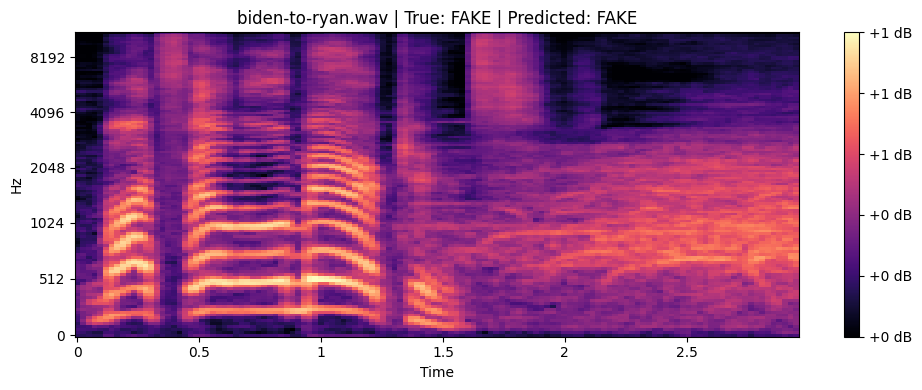

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

🔎 Sample 11
🎧 File: biden-original.wav
✅ True label: REAL
🤖 Predicted: REAL (99.98% confidence)
🔢 Softmax: [2.4180596e-04 9.9975818e-01]


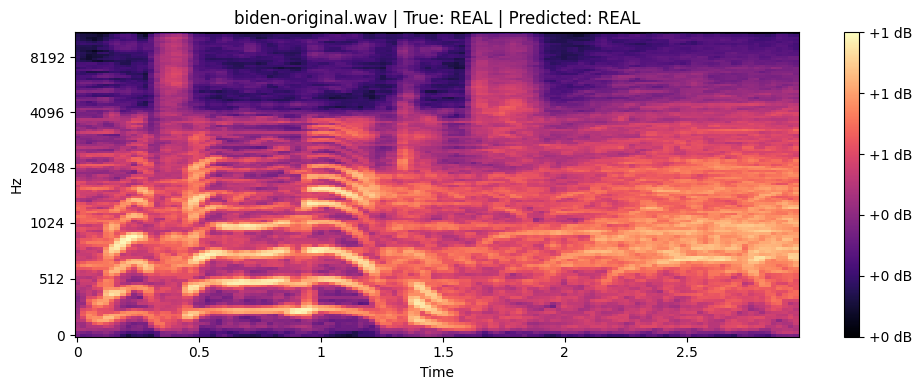

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

🔎 Sample 12
🎧 File: obama-original.wav
✅ True label: REAL
🤖 Predicted: REAL (99.84% confidence)
🔢 Softmax: [0.00162831 0.99837166]


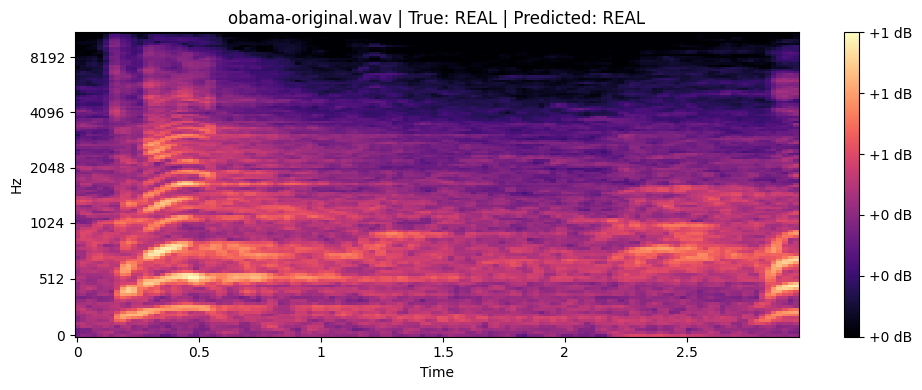

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

🔎 Sample 13
🎧 File: musk-to-ryan.wav
✅ True label: FAKE
🤖 Predicted: FAKE (100.00% confidence)
🔢 Softmax: [9.9999940e-01 5.5113605e-07]


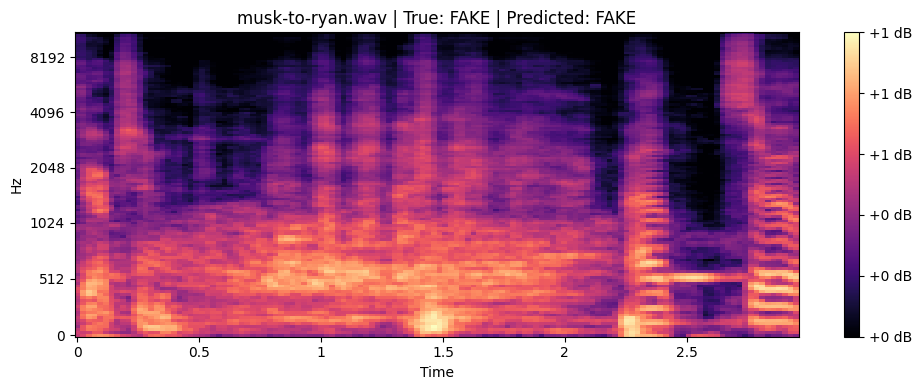

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

🔎 Sample 14
🎧 File: taylor-original.wav
✅ True label: REAL
🤖 Predicted: REAL (99.82% confidence)
🔢 Softmax: [0.00179102 0.998209  ]


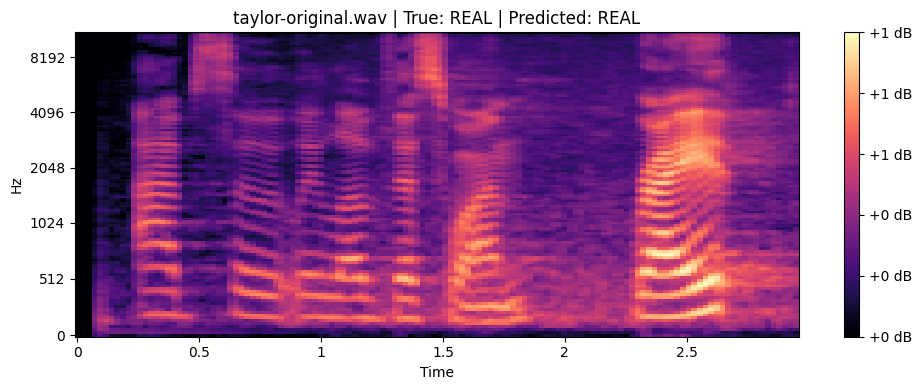

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

🔎 Sample 15
🎧 File: biden-original.wav
✅ True label: REAL
🤖 Predicted: REAL (99.98% confidence)
🔢 Softmax: [2.4180596e-04 9.9975818e-01]


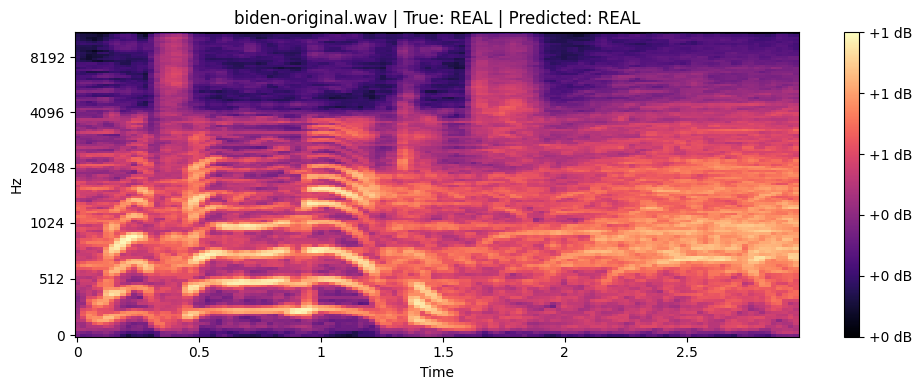

In [43]:
predict_and_show_multiple_spectrograms(real_audio_dir, fake_audio_dir, model, count=15)
